In [33]:
# classification model to identify the top predictors of stroke.

import pandas as pd #used to load and manipulate the dataset.
import numpy as np #used for numerical operations (like exponentiation for odds ratios).

from sklearn.model_selection import train_test_split
#preprocessing tools:
from sklearn.compose import ColumnTransformer #scale numeric columns.
from sklearn.preprocessing import OneHotEncoder #convert categorcal features to numeric.
from sklearn.preprocessing import StandardScaler #standardize numeric features.
from sklearn.pipeline import Pipeline #combine preprocessing steps and model into a single pipeline.
from sklearn.impute import SimpleImputer #fill median values for missing numeric data(BMI).
#metrics for evaluating model performance:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
#models:
from sklearn.linear_model import LogisticRegression 
#visualization:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay


In [13]:
df = pd.read_csv('data/stroke_dataset.csv')

In [14]:
print("Shape:", df.shape)
df.head()

Shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


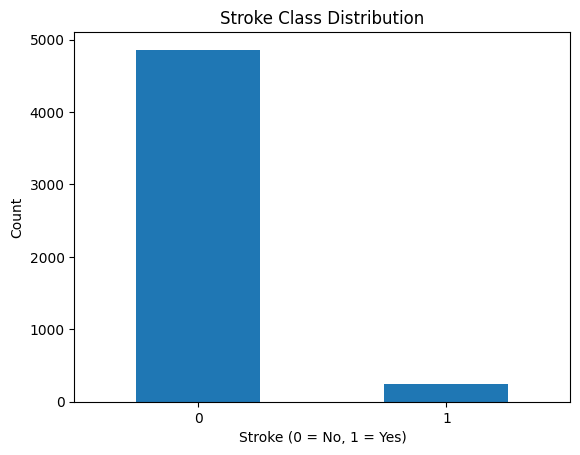

Percentage distribution:
stroke
0    95.13
1     4.87
Name: count, dtype: float64


In [15]:
#class distribution of the target variable (stroke) to understand the imbalance in the dataset.
stroke_counts = df["stroke"].value_counts()

plt.figure()
stroke_counts.plot(kind="bar")
plt.title("Stroke Class Distribution")
plt.xlabel("Stroke (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

print("Percentage distribution:")
print((stroke_counts / len(df) * 100).round(2))

In [20]:
target = "stroke"
X = df.drop(columns=[target]) #predictor variables (features).
y = df[target] #target variable (stroke).

In [21]:
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("\nTarget distribution:")
print(y.value_counts())

Feature matrix shape: (5110, 11)
Target vector shape: (5110,)

Target distribution:
stroke
0    4861
1     249
Name: count, dtype: int64


In [25]:
# Define feature groups by data type.

num_cols = ["age", "avg_glucose_level", "bmi"]
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
bin_cols = ["hypertension", "heart_disease"]  # already numeric but keep them in num pipeline or pass-through

In [28]:
# Split the dataset into training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

In [30]:
# # Build preprocessing pipelines for numeric and categorical features.
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine numeric and categorical transformers into a single ColumnTransformer.
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols + bin_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


In [ ]:


# 1) Logistic Regression baseline (handles imbalance via class_weight)
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)
proba_lr = logreg.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int) #yes/no predictions for confusion matrix.

print("LogReg ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("LogReg PR-AUC:", average_precision_score(y_test, proba_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_lr))
print(classification_report(y_test, pred_lr, digits=3))



LogReg ROC-AUC: 0.8581481481481481
LogReg PR-AUC: 0.21867707748592616
Confusion matrix:
 [[711 261]
 [ 11  39]]
              precision    recall  f1-score   support

           0      0.985     0.731     0.839       972
           1      0.130     0.780     0.223        50

    accuracy                          0.734      1022
   macro avg      0.557     0.756     0.531      1022
weighted avg      0.943     0.734     0.809      1022



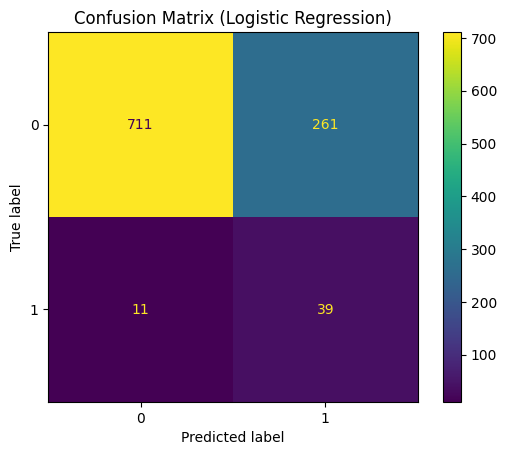

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr)
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

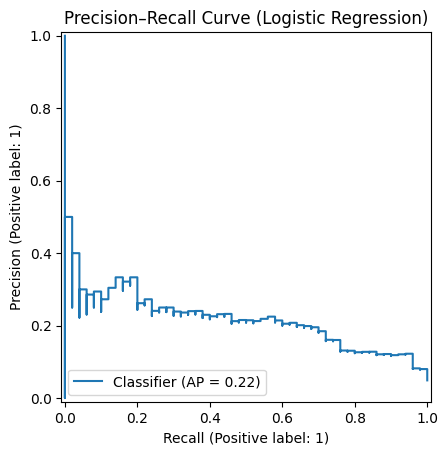

In [37]:
PrecisionRecallDisplay.from_predictions(y_test, proba_lr)
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.show()

The logistic regression model is able to detect most stroke cases, correctly identifying 39 out of 50 patients. However, it also produces a high number of false positives, meaning many people are flagged as high risk when they are not. Overall, the model favors catching stroke cases over avoiding false alarms, which can be appropriate in a medical screening setting where missing a stroke is more serious than over-predicting risk.

second part

In [10]:
# Get feature names after preprocessing
feature_names = logreg.named_steps["preprocess"].get_feature_names_out()

# Get model coefficients
coefficients = logreg.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients,
    "abs_coefficient": np.abs(coefficients)
})

coef_df = coef_df.sort_values("abs_coefficient", ascending=False)

coef_df.head(10)

,feature,coefficient,abs_coefficient
14,cat__work_type_children,0.796883,0.796883
3,num__hypertension,0.588147,0.588147
13,cat__work_type_Self-employed,-0.352230,0.352230
19,cat__smoking_status_never smoked,-0.256354,0.256354
20,cat__smoking_status_smokes,0.245269,0.245269
11,cat__work_type_Never_worked,-0.235098,0.235098
4,num__heart_disease,0.225691,0.225691
10,cat__work_type_Govt_job,-0.132875,0.132875
12,cat__work_type_Private,-0.106698,0.106698
9,cat__ever_married_Yes,-0.098201,0.098201


In [11]:
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df.head(10)

,feature,coefficient,abs_coefficient,odds_ratio
14,cat__work_type_children,0.796883,0.796883,2.218615
3,num__hypertension,0.588147,0.588147,1.800648
13,cat__work_type_Self-employed,-0.352230,0.352230,0.703118
19,cat__smoking_status_never smoked,-0.256354,0.256354,0.773868
20,cat__smoking_status_smokes,0.245269,0.245269,1.277964
11,cat__work_type_Never_worked,-0.235098,0.235098,0.790494
4,num__heart_disease,0.225691,0.225691,1.253188
10,cat__work_type_Govt_job,-0.132875,0.132875,0.875574
12,cat__work_type_Private,-0.106698,0.106698,0.898797
9,cat__ever_married_Yes,-0.098201,0.098201,0.906467


In [12]:
top3 = coef_df.sort_values("abs_coefficient", ascending=False).head(3)
top3

,feature,coefficient,abs_coefficient,odds_ratio
14,cat__work_type_children,0.796883,0.796883,2.218615
3,num__hypertension,0.588147,0.588147,1.800648
13,cat__work_type_Self-employed,-0.352230,0.352230,0.703118
